# TP1 : régression et propagation d'incertitudes

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

Ce TP a pour but d'utiliser différentes méthodes d'approximation pour 
interpoler des solutions obtenues par différences finies et étudier un problème de propagation d'incertitude.

On considère le problème de Poisson suivant : 
$$
\left\{\begin{array}{l}
- u''(x) =f, \quad \forall x\in ]0,1[\\
u(0)=u(1)=0,\end{array}\right.
$$
où $u : [0,1] \to \R$ est l'inconnue du problème et $f : [0,1] \to \R$ une fonction donnée.

Pour résoudre cette équation, on utilise une méthode de type différence finie. On considère donc une subdivision régulière $0 = x_0 \leq \ldots \leq x_{J+1}$ de l'intervalle $[0,1]$, avec $J \in \N^\ast$, $\Delta x = 1/J$ et $x_j = j \Delta x$ pour $j = 0,\ldots, J+1$. On cherche une solution approchée $u_j \approx u(x_j)$, pour $j = 1,\ldots, J$. Pour cela, on considère le schéma suivant
$$
\frac{-u_{j+1}+2u_j-u_{j-1}}{\Delta x^2} =f(x_j),\quad \forall j \in \{1,\ldots, J\}$$ 
$$ u_0=u_{J+1}=0
$$
qui se met sous forme matricielle $A u = b$.

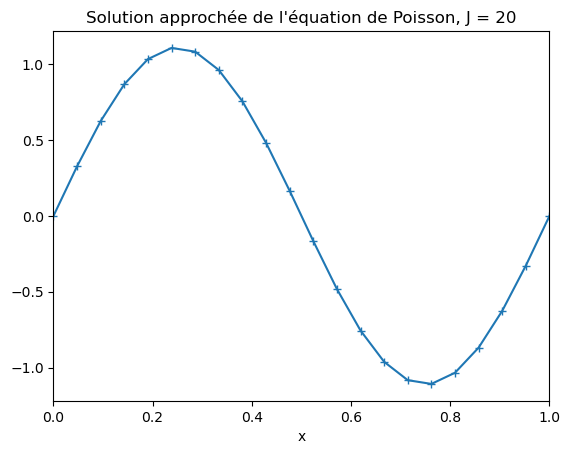

In [2]:
def matrix_poisson( J):
    dx = 1/J
    A = np.diag([2.]*J) + np.diag([-1]*(J-1), k=1) + np.diag([-1]*(J-1), k=-1) 
    A /= dx**2
    return A

def solve_poisson(J, f):
    mesh = np.linspace(0, 1, J+2)
    A = matrix_poisson( J)

    b = f(mesh[1:-1])
    u = np.zeros_like(mesh)
    u[1:-1] = np.linalg.solve(A, b)
    return mesh, u

J = 20
f = lambda x : 4.0 * (np.pi**2.0)*np.sin(2.0*np.pi*x)
mesh, u = solve_poisson( J, f)

plt.plot(mesh, u, '+-')
plt.xlim([0,1])
plt.xlabel('x')
plt.title("Solution approchée de l'équation de Poisson, J = "+str(J));

### Partie 1 - Régression

1. Programmer une méthode de régression polynomiale pour interpoler la solution approchée sur un maillage composé de $84$ points. Comparer le résultat obtenu en comparant avec la solution exacte.

In [3]:
class polynomialregression:

    def __init__(self, degree):
        self.degree = degree
        self.theta = np.zeros(degree+1)

    def fit(self, x_train, y_train):
        Phi = np.concatenate([x_train[None,:]**k for k in range(self.degree+1)], axis=0)
        self.theta = np.linalg.solve(Phi @ Phi.T, Phi @ y_train)

    def __call__(self, x_test):
        Phi = np.concatenate([x_test[None,:]**k for k in range(self.degree+1)], axis=0)
        return Phi.T @ self.theta

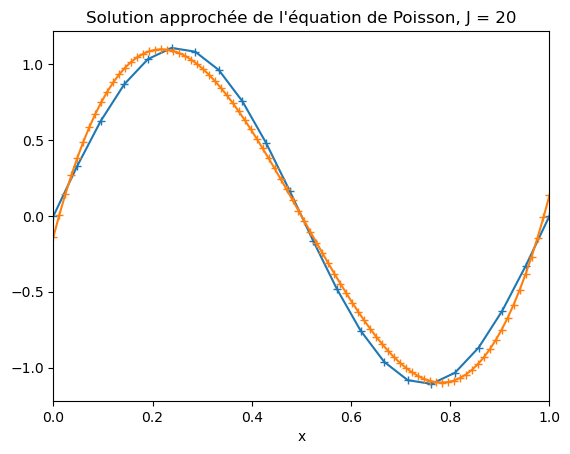

In [4]:
# creation du modèle
model = polynomialregression(degree=3)

# ajustement des paramètres aux données
x_train, y_train = mesh, u
model.fit(x_train, y_train)

# evaluation sur un maillage plus fin
x_test = np.linspace(0, 1, 84)
y_pred = model(x_test)

# affichage
plt.plot(x_train, y_train, '+-')
plt.plot(x_test, y_pred, '+-')
plt.xlim([0,1])
plt.xlabel('x')
plt.title("Solution approchée de l'équation de Poisson, J = "+str(J));

2. Reprennez la question précédente en utilisant la méthode de régression à noyau avec un noyau Gaussien.

In [5]:
class kernelregression:

    def __init__(self, kernel):
        self.kernel = kernel
        self.theta = None
        self.x_train = x_train

    def fit(self, x_train, y_train):
        K = self.kernel(np.abs(x_train[:,None] - x_train[None,:]))
        self.theta = np.linalg.solve(K @ K, K @ y_train)
        self.x_train = x_train

    def __call__(self, x_test):
        K = self.kernel(np.abs(x_test[:,None] - self.x_train[None,:]))
        return K @ self.theta

In [6]:
gaussian_kernel = lambda r, ell : np.exp(- r**2 / (2*ell**2))

# creation model
lambd = 0.1
ell = 0.02
kernel = lambda r: gaussian_kernel(r, lambd, ell)
model = kernelregression(kernel)

# ajustement des paramètres aux données
x_train, y_train = mesh, u
model.fit(x_train, y_train)

# evaluation sur un maillage plus fin
x_test = np.linspace(0, 1, 84)
y_pred = model(x_test)

# affichage
plt.plot(x_train, y_train, '+-')
plt.plot(x_test, y_pred, '+-')
plt.xlim([0,1])
plt.xlabel('x')
plt.title("Solution approchée de l'équation de Poisson, J = "+str(J));


TypeError: <lambda>() takes 2 positional arguments but 3 were given

2. Reprenez le même exercice avec un réseau de neurones de type dense (multi-layer perceptron).

In [ ]:
class mlp(torch.nn.Module):
    def __init__(self, layer_widths = list):
        super().__init__()

        self.layer_widths = layer_widths
        
        self.hidden_layers = []
        for i in range( len(layer_widths)-1):
            self.hidden_layers.append(torch.nn.Linear(self.layer_widths[i], self.layer_widths[i+1], dtype=torch.double))

        self.hidden_layers = torch.nn.ModuleList(self.hidden_layers)
        self.activation = torch.nn.Tanh()

    def forward(self, inputs):
        for i in range( len(self.layer_widths)-1):
                inputs = self.activation(self.hidden_layers[i].forward(inputs))
        return inputs


In [ ]:
# création du model
model = mlp([1, 30, 60, 120, 60, 30, 1])

# ajustement des paramètres aux données
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())
nb_epochs = 400
total_loss = 0

x_train = torch.from_numpy(mesh)[:,None]
x_train.requires_grad_()
y_train = torch.from_numpy(u)[:,None]

for epoch in range( nb_epochs):
    optimizer.zero_grad()
    y_pred = model(x_train)
    loss = criterion(y_pred,y_train)
    loss.backward()
    optimizer.step()

print("epoch "+ str(epoch)+': '+str(loss.item()))

epoch 399: 0.0026571112369855325


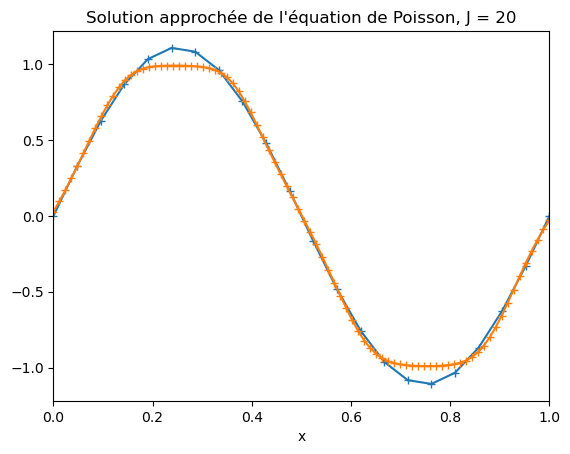

In [ ]:
x_test = torch.linspace(0, 1, 84, dtype=torch.double)[:,None]
y_test = model(x_test)

plt.plot(x_train.detach(), y_train.detach(), '+-')
plt.plot(x_test.detach(), y_test.detach(), '+-')
plt.xlim([0,1])
plt.xlabel('x')
plt.title("Solution approchée de l'équation de Poisson, J = "+str(J));